# Preprocessing Neural Response Data

In this example, we demonstrate how to use various preprocessing methods to prepare neural data for analysis using naplib-python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import naplib as nl
from naplib.preprocessing import filter_butter, normalize

### Load data

First, we load a single subject's EEG data from the [auditory attention decoding dataset](https://zenodo.org/record/1199011) published by *Fuglsang, et al.* This contains EEG responses from subjects listening to multitalker speech sounds with spatial separation, with the attended and unattended acoustic envelope as separate fields.

In [2]:
data = nl.io.import_outstruct('S1-Fuglsang.mat', strict=False)
data.fields

['name', 'envA', 'envU', 'resp', 'eog', 'dataf', 'filter']

### Frequency Range Filtering

First, we are interested in separating the responses into frequency bands.
* delta (0.5-4Hz)
* theta (4-8 Hz)
* alpha (8-13 Hz)
* beta (14-30Hz)

In [3]:
# filter the responses to different bands and set them as new fields of the Data

data['delta_resp'] = filter_butter(data, field='resp', Wn=[0.5, 4], order=5)
data['theta_resp'] = filter_butter(data, field='resp', Wn=[4, 8], order=5)
data['alpha_resp'] = filter_butter(data, field='resp', Wn=[8, 13], order=5)
data['beta_resp'] = filter_butter(data, field='resp', Wn=[13, 30], order=5)

#### To make sure the filter bands are correct or meet our requirements, get the filters used and plot them

If we are not satisfied with the filters, we can set the ``order`` parameter in the ``filter_butter`` function to increase the filter order.

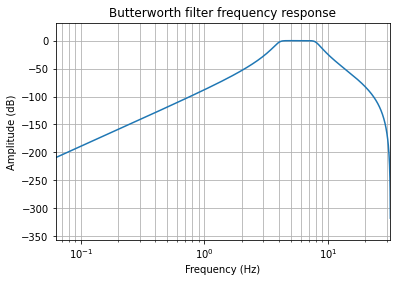

In [4]:
theta_resp, filters = filter_butter(data, Wn=[4, 8], return_filters=True, order=5)

# plot frequency response
nl.visualization.freq_response(filters[0], fs=data[0]['dataf'])

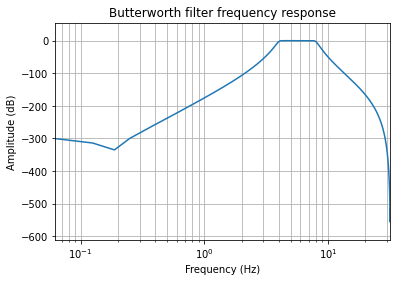

In [5]:
# use a higher order to get steeper cutoff region
theta_resp_2, filters_2 = filter_butter(data, Wn=[4, 8], order=10, return_filters=True)

# plot frequency response
nl.visualization.freq_response(filters_2[0], fs=data[0]['dataf'])

### Normalize filtered responses

Now that we have bandpassed responses, normalize each one (by z-scoring).

In [6]:
data['delta_resp'] = normalize(data, field='delta_resp')
data['theta_resp'] = normalize(data, field='theta_resp')
data['alpha_resp'] = normalize(data, field='alpha_resp')
data['beta_resp'] = normalize(data, field='beta_resp')

### Visualize frequency band responses

Here we just plot a single trial response across all electrodes.

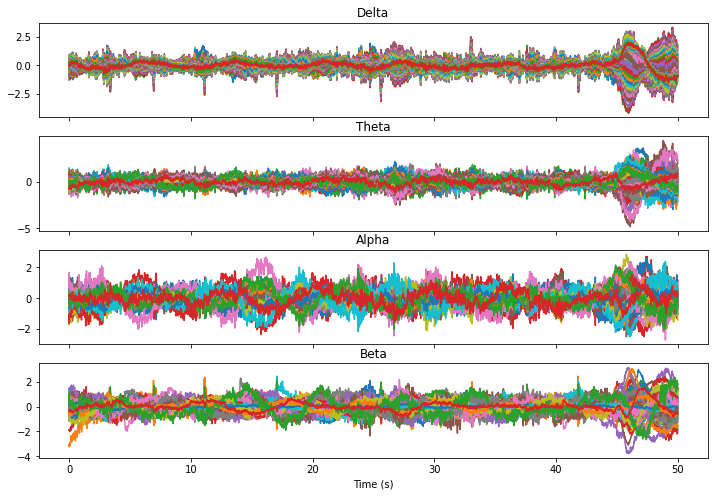

In [7]:
trial = 10
t = np.arange(0, data['delta_resp'][trial].shape[0]) / data['dataf'][trial]

fig, axes = plt.subplots(4,1,figsize=(12,8), sharex=True)

axes[0].plot(t, data['delta_resp'][trial])
axes[0].set_title('Delta')
axes[1].plot(t, data['theta_resp'][trial])
axes[1].set_title('Theta')
axes[2].plot(t, data['alpha_resp'][trial])
axes[2].set_title('Alpha')
axes[3].plot(t, data['beta_resp'][trial])
axes[3].set_title('Beta')
axes[3].set_xlabel('Time (s)')

plt.show()
